In [1]:
# Importing Modules 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.kalman_filter import FilterResults
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

In [3]:
# Read CSVs
df_SP = pd.read_csv('./DATA/INDICES/SP_OHLCV.csv', parse_dates=['Date'], infer_datetime_format=True, index_col="Date" )

# Compute stdev
stdev_window = 25
df_SP['stdev'] = df_SP['Close'].pct_change().rolling(window=stdev_window).std()

df_SP.dropna(inplace=True)
print(df_SP.shape)
df_SP.head()

(3001, 6)


,Open,High,Low,Close,Volume,stdev
Date,,,,,,
2010-11-09,1223.59,1226.84,1208.94,1213.40,484804000,0.006491
2010-11-10,1213.14,1218.75,1204.33,1218.71,456129984,0.006490
2010-11-11,1213.04,1215.45,1204.49,1213.54,393112000,0.006571
2010-11-12,1209.07,1210.50,1194.08,1199.21,421361984,0.007051
2010-11-15,1200.44,1207.43,1197.15,1197.75,350336992,0.007065


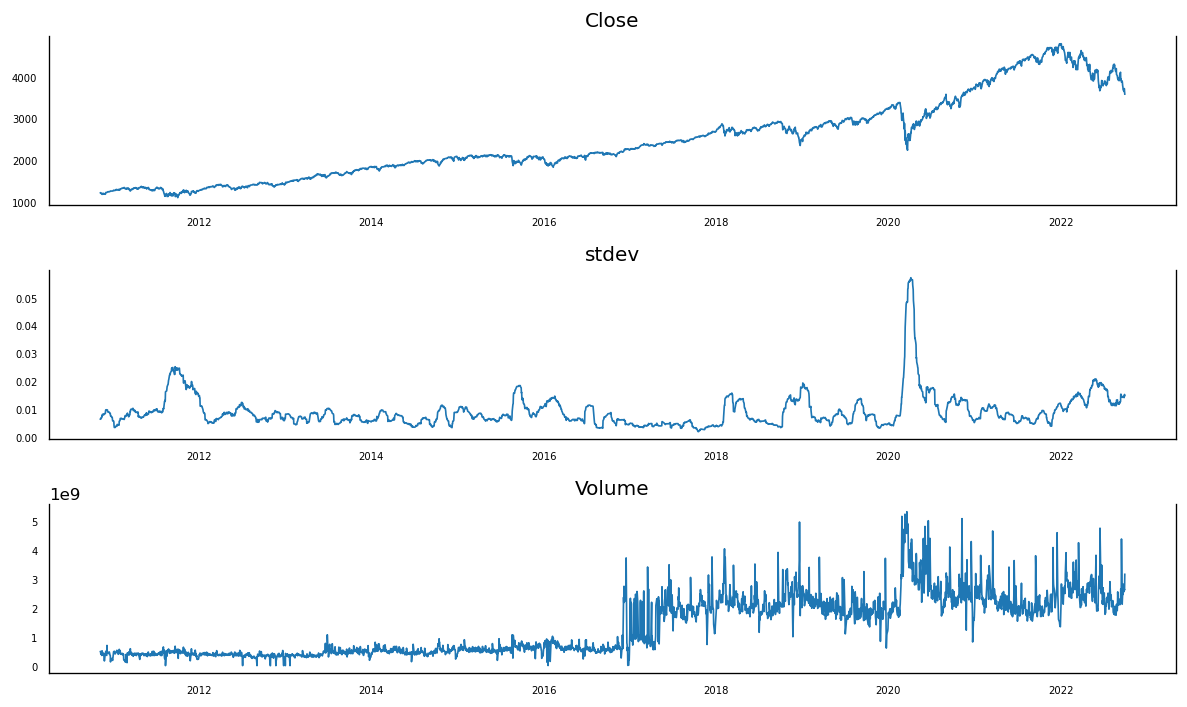

In [4]:
# Plot dataset
plot_grid(df_SP[['Close', 'stdev', 'Volume']], 3, 1)

In [5]:
# Check stationarity
def check_stationarity(df):
    non_stationary = []
    for column in df:
        adfuller_res = adfuller(df[column][1:])
        adf_stat = adfuller_res[0]
        p_value = adfuller_res[1]
        ci_1 = adfuller_res[-2]['1%']
        ci_5 = adfuller_res[-2]['5%']
        print(f'ADF Statistic ({column}): {adf_stat}')
        print(f'p-value: {p_value}')
        if adf_stat > ci_1 or adf_stat > ci_5:
            non_stationary.append(column)
            print(f'{column} is non stationary.')
        else:
            print(f'{column} is stationary!')
    
    if len(non_stationary) > 0:
        print(f'Non-stationary columns are: {non_stationary}. Try .diff()')
        return non_stationary
    else:
        print(f'All columns are stationary!')
    
non_stationary = check_stationarity(df_SP)

ADF Statistic (Open): -0.8711855048942081
p-value: 0.7973133095815654
Open is non stationary.
ADF Statistic (High): -0.7126736907236195
p-value: 0.8434393981279555
High is non stationary.
ADF Statistic (Low): -0.991528472261185
p-value: 0.7563415421794206
Low is non stationary.
ADF Statistic (Close): -0.7670880691538244
p-value: 0.8285990871606628
Close is non stationary.
ADF Statistic (Volume): -1.6278248447379127
p-value: 0.4686294802172849
Volume is non stationary.
ADF Statistic (stdev): -4.846214968599031
p-value: 4.433203065573355e-05
stdev is stationary!
Non-stationary columns are: ['Open', 'High', 'Low', 'Close', 'Volume']. Try .diff()


In [6]:
# Apply one .diff() on non stationary columns
df_SP_stationary = pd.concat([df_SP[non_stationary].diff(), df_SP.drop(columns=non_stationary)], axis=1).dropna()

In [7]:
# Check stationarity again
check_stationarity(df_SP_stationary)

ADF Statistic (Open): -51.17626351767842
p-value: 0.0
Open is stationary!
ADF Statistic (High): -10.886717906388638
p-value: 1.2545976325741245e-19
High is stationary!
ADF Statistic (Low): -17.485919659334602
p-value: 4.4634682522898355e-30
Low is stationary!
ADF Statistic (Close): -10.95595123714763
p-value: 8.561724002336917e-20
Close is stationary!
ADF Statistic (Volume): -16.8164915782806
p-value: 1.1876178966845297e-29
Volume is stationary!
ADF Statistic (stdev): -4.8441563203527185
p-value: 4.473909195191033e-05
stdev is stationary!
All columns are stationary!


In [8]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df_SP_stationary)
df_SP_scaled = scaler.transform(df_SP_stationary)
df_SP_scaled = pd.DataFrame(df_SP_scaled, columns=df_SP.columns).dropna()

# Number of .diff() methods performed for stationary conversion
n_diffs = 1

# Number of days in test & train set
n_train = 2500
n_test = len(df_SP) - n_train - n_diffs - stdev_window

# Split data
df_train = df_SP_scaled.iloc[:n_train]
df_test = df_SP_scaled.iloc[n_train:n_test+n_train]

# Create separate test set to preserve index for plotting predictions later
df_SP_test = df_SP.iloc[n_train:n_test+n_train]

print(f'Number of training days: {n_train}')
print(f'Number of testing days: {n_test}')

display(df_train.head(3))
display(df_test.head(3))

Number of training days: 2500
Number of testing days: 475


,Open,High,Low,Close,Volume,stdev
0,-0.053661,-0.049135,-0.020187,0.016344,-0.008898,0.113692
1,-0.000514,-0.020043,0.000701,-0.015913,-0.019556,0.115111
2,-0.020386,-0.030064,-0.045586,-0.044107,0.008766,0.123525


,Open,High,Low,Close,Volume,stdev
2500,-0.124166,-0.032189,0.131459,0.180061,-0.147622,0.271411
2501,0.255315,0.127665,0.190883,0.084275,0.004530,0.266883
2502,0.130379,0.212937,0.131021,0.093262,0.043162,0.238826


In [9]:
# Split exogenous and endogenous variables
# endog = df_train.drop(columns=['Volume'])
# exog = df_train['Volume']

# Create VARMAX Model
model = VARMAX(
    df_train,
    order=(1,1),
    # error_cov_type='diagonal',
    filter_concentrated=True
)

# Fit model
model_fit = model.fit(disp=True)
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           99     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04695D+01    |proj g|=  1.38964D+01


 This problem is unconstrained.



At iterate    1    f= -1.04728D+01    |proj g|=  7.81875D+00

At iterate    2    f= -1.04739D+01    |proj g|=  3.23673D+00

At iterate    3    f= -1.04746D+01    |proj g|=  2.83993D+00

At iterate    4    f= -1.04756D+01    |proj g|=  4.57983D+00

At iterate    5    f= -1.04771D+01    |proj g|=  4.89703D+00

At iterate    6    f= -1.04795D+01    |proj g|=  6.35060D+00

At iterate    7    f= -1.04817D+01    |proj g|=  5.25763D+00

At iterate    8    f= -1.04834D+01    |proj g|=  2.30676D+00

At iterate    9    f= -1.04848D+01    |proj g|=  2.77183D+00

At iterate   10    f= -1.04856D+01    |proj g|=  2.80144D+00

At iterate   11    f= -1.04869D+01    |proj g|=  7.67641D+00

At iterate   12    f= -1.04887D+01    |proj g|=  1.66343D+00

At iterate   13    f= -1.04893D+01    |proj g|=  1.57147D+00

At iterate   14    f= -1.04894D+01    |proj g|=  5.00536D+00

At iterate   15    f= -1.04898D+01    |proj g|=  8.60626D-01

At iterate   16    f= -1.04898D+01    |proj g|=  6.07035D-01

At iter

Dep. Variable:,"['Open', 'High', 'Low', 'Close', 'Volume', 'stdev']",No. Observations:,2500
Model:,"VARMA(1,1)",Log Likelihood,26255.489
,+ intercept,AIC,-52310.979
Date:,"Tue, 04 Oct 2022",BIC,-51728.574
Time:,06:53:05,HQIC,-52099.538
Sample:,0,Scale,0.885
,- 2500,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"68.48, 1.39, 0.52, 8.37, 1.23, 1.30",Jarque-Bera (JB):,"120534.69, 9665.24, 13257.15, 32534.68, 25910.88, 67497.85"
Prob(Q):,"0.00, 0.24, 0.47, 0.00, 0.27, 0.25",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"11.29, 3.12, 4.79, 4.16, 18.61, 2.70",Skew:,"-1.81, 0.82, -1.36, -0.81, 0.56, -0.63"


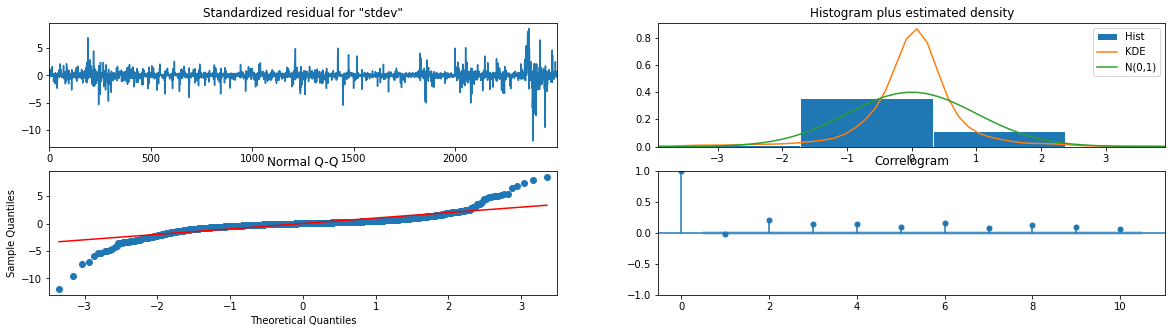

In [10]:
# Plot stdev diagnostics
model_fit.plot_diagnostics(5,figsize=(20,5));

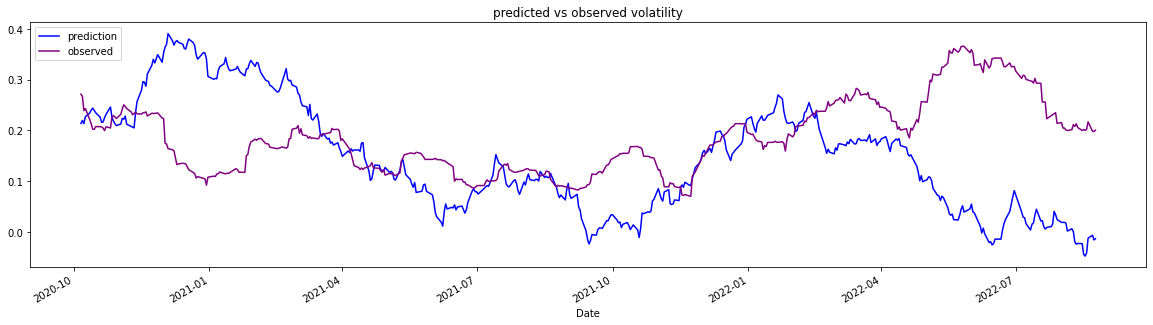

In [11]:
# Set random seed
np.random.seed(1)

# Plot predicted vs observed volatility
pred = pd.DataFrame(index=df_SP_test.index)
pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True).stdev
pred['observed'] = df_test.set_index(pred.index, drop=True).stdev
pred.plot(figsize=(20,5),title='predicted vs observed volatility',color=['blue','purple'])
plt.legend(loc=('upper left'));

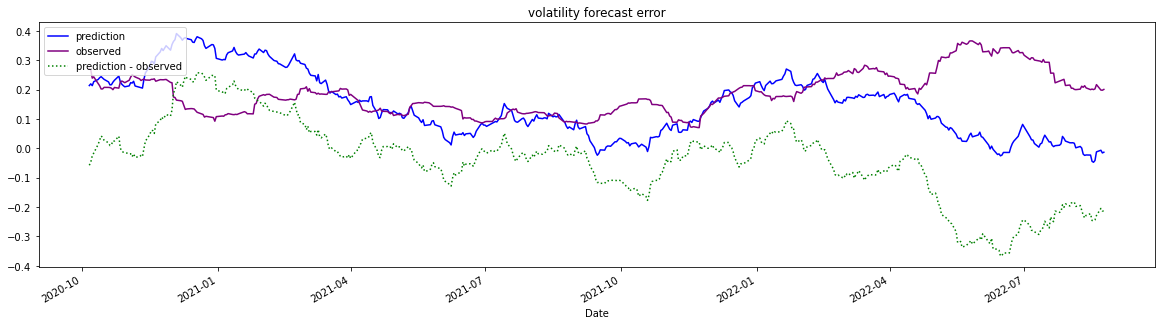

In [12]:
# Plot error
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
plt.legend(loc=('upper left'));

In [13]:
error_total = np.round(np.sum(np.abs(pred['prediction - observed'])), 2)
print(f'Total Error: {error_total}')

Total Error: 48.48


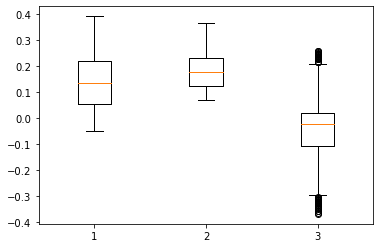

In [14]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(pred)
plt.show()

In [15]:
pred.describe()[min]

count    475.000000
mean       0.185467
std        0.070847
min        0.070303
25%        0.123579
50%        0.177545
75%        0.231197
max        0.365717
Name: observed, dtype: float64

In [16]:
pred

,prediction,observed,prediction - observed
Date,,,
2020-10-06,0.213558,0.271411,-0.057853
2020-10-07,0.219374,0.266883,-0.047509
2020-10-08,0.213214,0.238826,-0.025612
2020-10-09,0.226757,0.243135,-0.016378
2020-10-12,0.234311,0.220928,0.013383
...,...,...,...
2022-08-18,-0.041667,0.202220,-0.243887
2022-08-19,-0.012259,0.216785,-0.229044
2022-08-22,-0.006704,0.198138,-0.204842


In [33]:
pred['signal'] =  np.where(pred['prediction']>pred["observed"].shift().describe().loc["min"], 1,
        np.where(pred["prediction"]<pred["observed"].shift().describe().loc["max"], -1,
        0))

In [34]:
pred

,prediction,observed,prediction - observed,signal
Date,,,,
2020-10-06,0.213558,0.271411,-0.057853,1
2020-10-07,0.219374,0.266883,-0.047509,1
2020-10-08,0.213214,0.238826,-0.025612,1
2020-10-09,0.226757,0.243135,-0.016378,1
2020-10-12,0.234311,0.220928,0.013383,1
...,...,...,...,...
2022-08-18,-0.041667,0.202220,-0.243887,-1
2022-08-19,-0.012259,0.216785,-0.229044,-1
2022-08-22,-0.006704,0.198138,-0.204842,-1


In [35]:
ic_25 = df_train['stdev'].describe()['25%']
ic_75 = df_train['stdev'].describe()['75%']
print(ic_25)
print(ic_75)

0.09789978377560463
0.17566274173613508


In [36]:
df_trading = pred[['observed', 'prediction']]
df_trading['signal'] = 0.0
df_trading.head(3)

,observed,prediction,signal
Date,,,
2020-10-06,0.271411,0.213558,0.0
2020-10-07,0.266883,0.219374,0.0
2020-10-08,0.238826,0.213214,0.0


In [47]:
def get_signals(df):  
    df['signal'] = np.where(df["prediction"]>df["observed"].shift().describe().loc["25%"], 1,\
                            np.where(df["prediction"]<df["observed"].shift().describe().loc["75%"], -1,0))

    print(df_trading['signal'].value_counts())
    
get_signals(df_trading)

 1    247
-1    228
Name: signal, dtype: int64


In [48]:
df_trading['signal']

Date
2020-10-06    1
2020-10-07    1
2020-10-08    1
2020-10-09    1
2020-10-12    1
             ..
2022-08-18   -1
2022-08-19   -1
2022-08-22   -1
2022-08-23   -1
2022-08-24   -1
Name: signal, Length: 475, dtype: int64

In [23]:
def trading_algo(df): 
    if df[df['prediction - observed'] >= 0.1]:
        print('sell')
    elif df[df['prediction - observed'] == 1]: 
        print('idk')
    elif df[df['prediction - observed'] < 0]:
        print('buy')
    else: 
        print('no_change')
        
    return portfolio_choice

In [49]:
df_trading

,observed,prediction,signal
Date,,,
2020-10-06,0.271411,0.213558,1
2020-10-07,0.266883,0.219374,1
2020-10-08,0.238826,0.213214,1
2020-10-09,0.243135,0.226757,1
2020-10-12,0.220928,0.234311,1
...,...,...,...
2022-08-18,0.202220,-0.041667,-1
2022-08-19,0.216785,-0.012259,-1
2022-08-22,0.198138,-0.006704,-1


In [50]:

import os 
directory = ('./DATA/ETF_CYC')

cyclical_etfs = pd.DataFrame()


for root,dirs, files in os.walk(directory):
    for filename in files: 
        cyc_path  = (os.path.join(root, filename))


        cyc_df = pd.read_csv(cyc_path, parse_dates=True, infer_datetime_format=True, index_col='Date')
        cyc_df.rename(columns={'Close': cyc_path[-7:-4]}, inplace=True)
        cyclical_etfs = pd.concat([cyclical_etfs, cyc_df.pct_change()], axis=1)
        cyclical_etfs.dropna(inplace=True)
        
cyclical_etfs.index=pd.to_datetime(cyclical_etfs.index.date)
cyclical_etfs
        
        

,VCR,ITB,XLY,IYC,PEJ
2010-09-29,-0.004809,-0.011570,-0.007113,-0.004551,-0.003077
2010-09-30,-0.001487,0.007525,-0.002687,-0.001960,-0.000617
2010-10-01,0.001862,-0.003320,0.001197,0.000654,0.006794
2010-10-04,-0.004274,-0.012490,-0.002093,-0.005886,-0.004294
2010-10-05,0.021086,0.012648,0.020971,0.018421,0.023413
...,...,...,...,...,...
2022-09-19,0.013549,0.022472,0.012030,0.012350,0.011914
2022-09-20,-0.018229,-0.019636,-0.016954,-0.017295,-0.007167
2022-09-21,-0.022242,-0.012312,-0.023675,-0.020899,-0.041248
2022-09-22,-0.024884,-0.012279,-0.023075,-0.023431,-0.028502


In [51]:
import os 
directory = ('./DATA/ETF_DEF')

defensive_etfs = pd.DataFrame()

for root,dirs, files in os.walk(directory):
    for filename in files: 
        def_path = (os.path.join(root, filename))
        
        def_df = pd.read_csv(def_path, parse_dates=True, infer_datetime_format=True, index_col='Date')
        def_df.rename(columns={'Close': def_path[-7:-4]}, inplace=True)
        defensive_etfs = pd.concat([defensive_etfs,def_df.pct_change()], axis=1)
        defensive_etfs.dropna(inplace=True)
    
    
defensive_etfs
defensive_etfs.index=pd.to_datetime(defensive_etfs.index.date)

In [52]:
defensive_etfs['return'] = defensive_etfs.sum(axis=1)

defensive_etfs['signal'] = df_trading['signal']
defensive_etfs['strategy_return'] = defensive_etfs['return'] * defensive_etfs['signal']
defensive_etfs.dropna(inplace=True)

defensive_etfs

,VDC,KXI,XLP,IYK,PBJ,return,signal,strategy_return
2020-10-06,-0.006307,-0.009653,-0.006509,-0.011388,-0.004195,-0.038053,1.0,-0.038053
2020-10-07,0.011473,0.008664,0.010763,0.018552,0.009028,0.058480,1.0,0.058480
2020-10-08,0.006758,0.004474,0.006636,0.006049,0.003281,0.027197,1.0,0.027197
2020-10-09,0.007551,0.008730,0.007818,0.009150,0.016647,0.049897,1.0,0.049897
2020-10-12,0.012134,0.008478,0.011561,0.010946,0.010526,0.053644,1.0,0.053644
...,...,...,...,...,...,...,...,...
2022-08-18,0.003428,-0.002115,0.003381,0.001309,0.008491,0.014494,-1.0,-0.014494
2022-08-19,-0.004020,-0.004239,-0.003240,0.000145,0.001263,-0.010090,-1.0,0.010090
2022-08-22,-0.010847,-0.008841,-0.010142,-0.010018,-0.010090,-0.049938,-1.0,0.049938
2022-08-23,-0.004335,-0.006277,-0.004335,-0.004742,0.002336,-0.017353,-1.0,0.017353


In [53]:
cyclical_etfs['return'] = cyclical_etfs.sum(axis=1)

cyclical_etfs['signal'] = df_trading['signal']
cyclical_etfs['strategy_return'] = cyclical_etfs['return'] * cyclical_etfs['signal']
cyclical_etfs.dropna(inplace=True)

cyclical_etfs

,VCR,ITB,XLY,IYC,PEJ,return,signal,strategy_return
2020-10-06,-0.018287,-0.017756,-0.018505,-0.017279,-0.008984,-0.080811,1.0,-0.080811
2020-10-07,0.024246,0.011057,0.022855,0.020141,0.015005,0.093303,1.0,0.093303
2020-10-08,0.006062,0.025864,0.006564,0.006738,0.002772,0.048000,1.0,0.048000
2020-10-09,0.011806,0.007953,0.010408,0.005136,0.000921,0.036224,1.0,0.036224
2020-10-12,0.013288,0.005372,0.013299,0.009910,0.003682,0.045552,1.0,0.045552
...,...,...,...,...,...,...,...,...
2022-08-18,-0.000106,0.000808,-0.000292,-0.000719,0.004804,0.004495,-1.0,-0.004495
2022-08-19,-0.023570,-0.028747,-0.020636,-0.020587,-0.015539,-0.109080,-1.0,0.109080
2022-08-22,-0.028866,-0.022281,-0.027756,-0.028370,-0.026226,-0.133500,-1.0,0.133500
2022-08-23,0.003270,-0.005102,0.002824,0.000454,0.005736,0.007181,-1.0,-0.007181


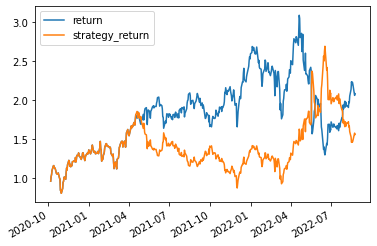

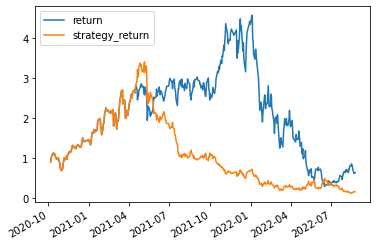

In [54]:
defensive_plot = (1 + defensive_etfs[["return", "strategy_return"]]).cumprod().plot.line()
cyclical_plot = (1 + cyclical_etfs[["return", "strategy_return"]]).cumprod().plot.line()

In [55]:
def_stratreturns = (1 + defensive_etfs[['return', 'strategy_return']]).cumprod().iloc[-1]
cyc_stratreturns = (1 + cyclical_etfs[['return', 'strategy_return']]).cumprod().iloc[-1]

In [56]:
def_stratreturns

return             2.083217
strategy_return    1.559586
Name: 2022-08-24 00:00:00, dtype: float64

In [57]:
cyc_stratreturns

return             0.649031
strategy_return    0.166221
Name: 2022-08-24 00:00:00, dtype: float64